In [128]:
import numpy as np
import os
import torch
import pickle

from collections import defaultdict

from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from loguru import logger
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from Tracklet import Tracklet

import argparse
from copy import copy
import shutil
import cv2 as cv

In [2]:
from merge_tracklets_groups import(
    get_distance_matrix, get_distance, get_spatial_constraints,
    split_tracklets, merge_tracklets, save_results
)

In [3]:
# seq_tracks_dir="F:\\Dataset\\test_merge_videos_tracklets\\seq_temporal"
seq_tracks_dir="F:\\Dataset\\test_merge_videos_tracklets\\seq_split&merged"

In [4]:
seqs_tracks = os.listdir(seq_tracks_dir)
seqs_tracks.sort()
seqs_tracks

['seq_1.pkl', 'seq_2.pkl']

In [5]:
tracklets_spartial = {}

for seq_idx, seq in enumerate(seqs_tracks):
    seq_idx = int(seq_idx)

    seq_name = seq.split('.')[0] 
    logger.info(f"Processing seq {seq_idx+1} / {len(seqs_tracks)}")
    with open(os.path.join(seq_tracks_dir, seq), 'rb') as pkl_f:
        tmp_trklets = pickle.load(pkl_f)     # dict(key:track id, value:tracklet)

    tracklets_spartial[seq_idx] = {
        "tracklets": tmp_trklets, 
        "time_delta":max([max(tracklet.times) for _,tracklet in tmp_trklets.items()]),
        "max_trackid": max(tmp_trklets.keys()),
    }

2025-07-14 11:30:07.707 | INFO     | __main__:<module>:7 - Processing seq 1 / 2
2025-07-14 11:30:08.607 | INFO     | __main__:<module>:7 - Processing seq 2 / 2


In [6]:
def get_cross_distance_matrix(tid2track1, tid2track2):
    """
    Constructs and returns a distance matrix between all tracklets based on overlapping times and feature similarities.

    Args:
        tid2track (dict): Dictionary mapping track IDs to their respective track objects.

    Returns:
        ndarray: A square matrix where each element (i, j) represents the calculated distance between track i and track j.
    """
    # print("number of tracks:", len(tid2track))
    Dist = np.zeros((len(tid2track1), len(tid2track2)))

    for i, (track1_id, track1) in enumerate(tid2track1.items()):
        assert len(track1.times) == len(track1.bboxes)
        for j, (track2_id, track2) in enumerate(tid2track2.items()):
            Dist[i][j] = get_distance(track1_id, track2_id, track1, track2)
    return Dist

In [7]:
len(tracklets_spartial[0]['tracklets']), len(tracklets_spartial[1]['tracklets'])

(64, 72)

In [13]:
np.unique(tracklets_spartial[0]['tracklets'].keys()), np.unique(tracklets_spartial[1]['tracklets'].keys())

(array([dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 42.0, 44.0, 46.0, 47.0, 48.0, 49.0, 50.0, 52.0, 53.0, 9.0, 43.0, 54.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 45.0, 51.0, 20.0, 55.0, 21.0, 22.0, 56.0, 23.0, 24.0, 25.0, 26.0, 27.0, 58.0, 28.0, 61.0, 62.0, 29.0, 60.0, 63.0, 30.0, 31.0, 64.0, 59.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 57.0, 39.0, 40.0, 41.0])],
       dtype=object),
 array([dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 48.0, 49.0, 50.0, 53.0, 55.0, 57.0, 58.0, 59.0, 52.0, 54.0, 60.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 61.0, 51.0, 62.0, 15.0, 56.0, 16.0, 63.0, 65.0, 17.0, 67.0, 64.0, 18.0, 19.0, 20.0, 21.0, 68.0, 69.0, 22.0, 66.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 70.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 71.0, 72.0, 47.0])],
       dtype=object))

In [8]:
tracklets_spartial[0]['max_trackid'], tracklets_spartial[1]['max_trackid']

(64.0, 72.0)

In [9]:
dist_groups =  get_cross_distance_matrix(
    tracklets_spartial[0]['tracklets'],
    tracklets_spartial[1]['tracklets'],
)

<Axes: >

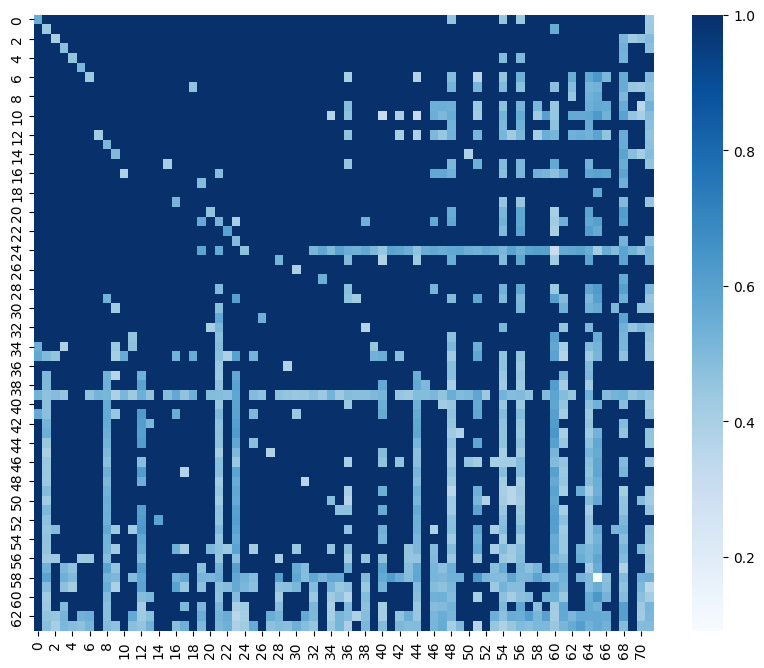

In [10]:
plt.figure(figsize=(10, 8))  # Optional: adjust the size of the heatmap
# Plot the heatmap
sns.heatmap(dist_groups, cmap='Blues')

In [19]:
tracklets_spartial[0]['time_delta'], tracklets_spartial[1]['time_delta']

(1773.0, 1749.0)

In [13]:
# (np.asarray(tracklets_spartial[0]['tracklets'][1.0].times) + 200).tolist()

Two variants:
1. add to times of second tracklets group max delta of the first groupr and give second tracklets numbers larger
2. perform merge of ends of first group tracklet's ends and starts of second group.

In [14]:
all_tracklets = {}
time_thresh = 100
glob_id = 0
time_delta = 0.0
for _, value in tracklets_spartial.items():
    last_tracklets_time = value['time_delta']
    for id, trk in value['tracklets'].items():
        trk_times = trk.times
        trk_max_time = max(trk_times)
        if trk_max_time >= last_tracklets_time - time_thresh:
            # tracklet is ended with video, so add it for merging:
            all_tracklets[glob_id] = trk
            all_tracklets[glob_id].track_id = glob_id
            all_tracklets[glob_id].times = (np.asarray(trk_times) + time_delta).tolist()
            glob_id += 1
    time_delta += last_tracklets_time
    

In [15]:
len(all_tracklets)

88

In [17]:
spatial_factor = 1
min_len = 100
eps = 0.7
min_samples = 10
max_k = 3
merge_dist_thres = 0.4

In [18]:
max_x_range, max_y_range = get_spatial_constraints(all_tracklets, spatial_factor)

In [19]:
Dist = get_distance_matrix(all_tracklets)

In [20]:
seq2Dist = dict()
seq2Dist[seq_name] = Dist

<Axes: >

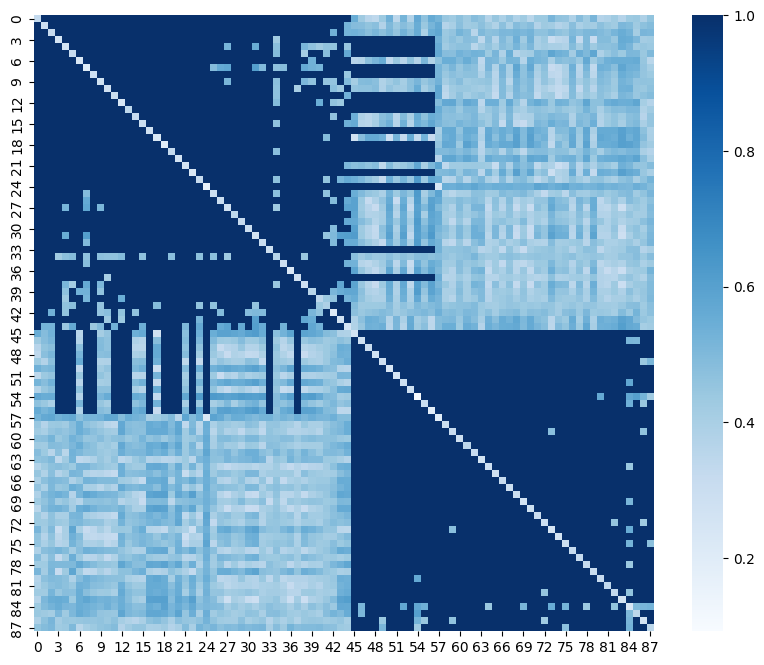

In [21]:
plt.figure(figsize=(10, 8))  # Optional: adjust the size of the heatmap
# Plot the heatmap
sns.heatmap(Dist, cmap='Blues')

In [22]:
splitTracklets = split_tracklets(
    all_tracklets, eps=eps, max_k=max_k, min_samples=min_samples, len_thres=min_len)

Splitting tracklets: 100%|██████████| 88/88 [00:00<00:00, 98.10it/s] 


In [23]:
len(splitTracklets)

97

In [24]:
Dist = get_distance_matrix(splitTracklets)

<Axes: >

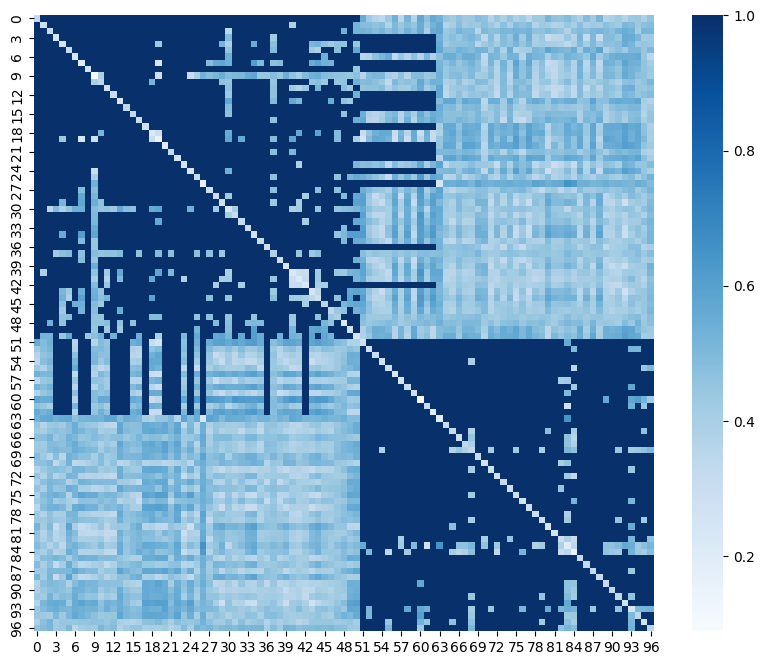

In [25]:
plt.figure(figsize=(10, 8))  # Optional: adjust the size of the heatmap
# Plot the heatmap
sns.heatmap(Dist, cmap='Blues')

In [ ]:
mergedTracklets = merge_tracklets(
    splitTracklets, 
    seq2Dist, 
    Dist, 
    seq_name=seq_name,
    max_x_range=max_x_range, 
    max_y_range=max_y_range, 
    merge_dist_thres=merge_dist_thres
)

1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4
1.0  > 0.4


----------------Number of tracklets after merging: 52----------------


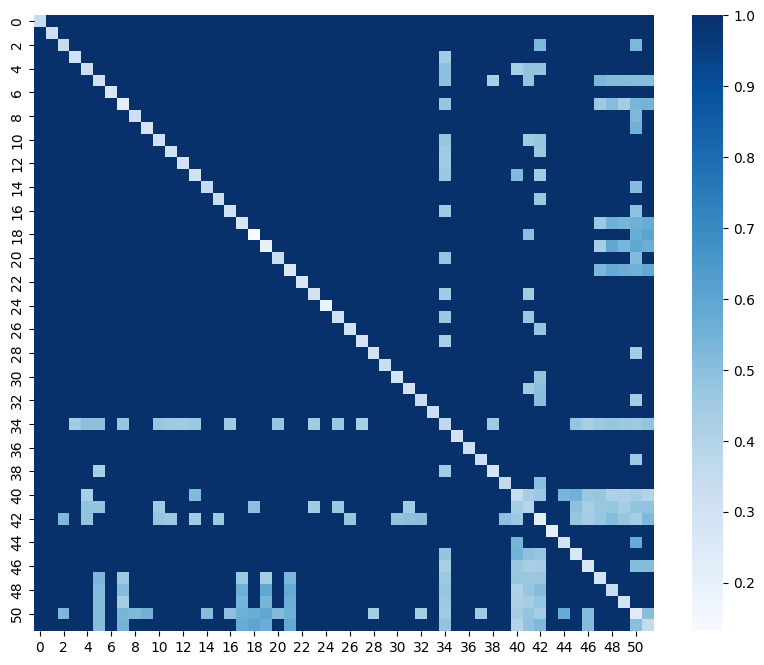

In [27]:
Dist = get_distance_matrix(mergedTracklets)
plt.figure(figsize=(10, 8))  # Optional: adjust the size of the heatmap
# Plot the heatmap
sns.heatmap(Dist, cmap='Blues')
print(f"----------------Number of tracklets after merging: {len(mergedTracklets)}----------------")

In [109]:
# def save_results(sct_output_path, tracklets):
#     """
#     Saves the final tracklet results into a specified path.

#     Args:
#         sct_output_path (str): Path where the results will be saved.
#         tracklets (dict): Dictionary of tracklets containing their final states.

#     """
#     results = []

#     for i, tid in enumerate(sorted(tracklets.keys())): # add each track to results
#         track = tracklets[tid]
#         tid = i + 1
#         for instance_idx, frame_id in enumerate(track.times):
#             bbox = track.bboxes[instance_idx]
            
#             results.append(
#                 [frame_id, tid, bbox[0], bbox[1], bbox[2], bbox[3], 1, -1, -1, -1]
#             )
#     results = sorted(results, key=lambda x: x[0])
#     txt_results = []
#     for line in results:
#         txt_results.append(
#             f"{line[0]},{line[1]},{line[2]:.2f},{line[3]:.2f},{line[4]:.2f},{line[5]:.2f},{line[6]},{line[7]},{line[8]},{line[9]}\n"
#             )
    
#     # NOTE: uncomment to save results
#     with open(sct_output_path, 'w') as f:
#         f.writelines(txt_results)
#     logger.info(f"save SCT results to {sct_output_path}")

In [42]:
def copy_and_rename_images(src_dirs, output_dir, tracklets_spartial):
    os.makedirs(output_dir, exist_ok=True)
    delta = 0.0
    for i, src_dir in enumerate(src_dirs):        
        for img_name in os.listdir(src_dir):
            # Extract numeric part and convert to float
            base, ext = os.path.splitext(img_name)
            try:
                img_num = float(base)
            except ValueError:
                continue  # skip non-numeric filenames
            new_img_num = img_num + delta
            new_img_name = f"{new_img_num:.1f}{ext}"
            src_path = os.path.join(src_dir, img_name)
            dst_path = os.path.join(output_dir, new_img_name)
            shutil.copy2(src_path, dst_path)
        delta += tracklets_spartial[i]['time_delta']

In [40]:
save_results("F:\\Dataset\\test_merge_videos_tracklets\\seq_merged.txt", mergedTracklets)

2025-07-11 01:55:39.393 | INFO     | merge_tracklets_groups:save_results:649 - save SCT results to F:\Dataset\test_merge_videos_tracklets\seq_merged.txt


In [39]:
IMG_DIR1 = "F:\\Dataset\\test_merge_videos_tracklets\\part1\\outputs\\seq_0\\img1"
IMG_DIR2 = "F:\\Dataset\\test_merge_videos_tracklets\\part2\\outputs\\seq_0\\img1"
OUTPUT_DIR = "F:\\Dataset\\test_merge_videos_tracklets\\merged_images"

In [43]:
copy_and_rename_images([IMG_DIR1, IMG_DIR2], OUTPUT_DIR, tracklets_spartial)

### 2. Try to find close tracklets

In [17]:
def plot_trajectory(tracklet):
    """
    Plots the trajectory of an object from its tracklet data.
    
    Parameters:
    tracklet (list of lists): Each inner list is a bounding box [x, y, width, height].
    """
    # Extract center coordinates (x, y) for each bounding box
    centers_x = []
    centers_y = []
    
    for bbox in tracklet:
        x, y, w, h = bbox
        center_x = x + w / 2  # Calculate center x-coordinate
        center_y = y + h / 2  # Calculate center y-coordinate
        centers_x.append(center_x)
        centers_y.append(center_y)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(centers_x, centers_y, 'bo-', linewidth=2, markersize=8, label='Trajectory')  # Blue line with circle markers
    plt.scatter(centers_x[0], centers_y[0], color='green', s=100, zorder=5, label='Start')  # Green dot for start
    plt.scatter(centers_x[-1], centers_y[-1], color='red', s=100, zorder=5, label='End')    # Red dot for end
    
    plt.title('Object Trajectory', fontsize=14)
    plt.xlabel('X-coordinate (pixels)', fontsize=12)
    plt.ylabel('Y-coordinate (pixels)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().invert_yaxis()  # Match image coordinate system (origin at top-left)
    plt.tight_layout()
    plt.show()

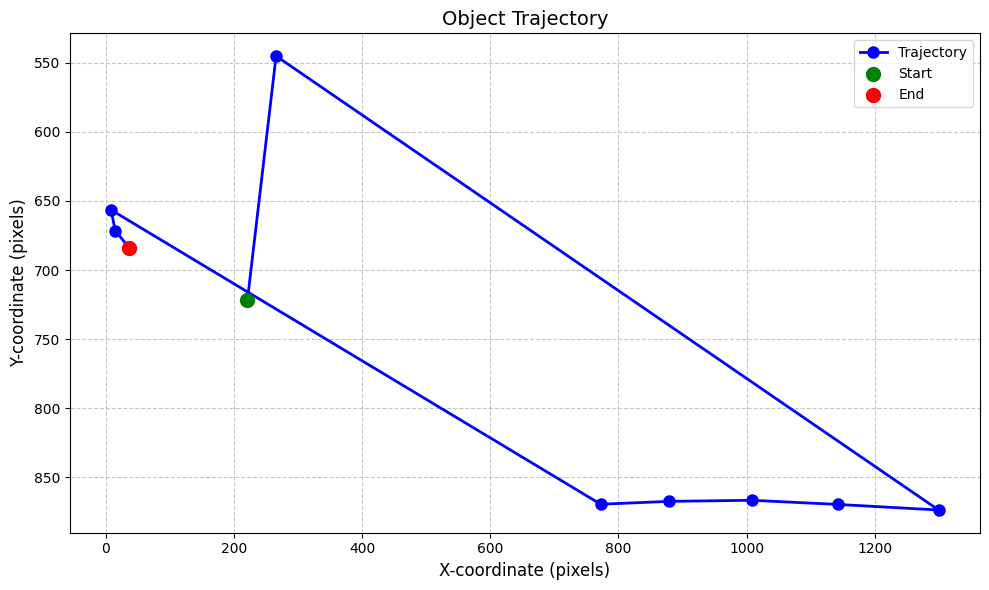

In [37]:
plot_trajectory(tracklets_spartial[1]['tracklets'][30.0].bboxes[-10:])

In [272]:
def calculate_bbox_distance(bbox1: List[float], bbox2: List[float]) -> float:
    """Calculate Euclidean distance between two bounding box centers"""
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    
    # Calculate centers
    center1_x = x1 + w1 / 2
    center1_y = y1 + h1 / 2
    center2_x = x2 + w2 / 2
    center2_y = y2 + h2 / 2
    
    return np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)

In [273]:
def calculate_bbox_overlap(bbox1: List[float], bbox2: List[float]) -> float:
    """Calculate IoU (Intersection over Union) between two bounding boxes"""
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    
    # Calculate intersection
    left = max(x1, x2)
    top = max(y1, y2)
    right = min(x1 + w1, x2 + w2)
    bottom = min(y1 + h1, y2 + h2)
    
    if left < right and top < bottom:
        intersection = (right - left) * (bottom - top)
    else:
        intersection = 0
    
    # Calculate union
    area1 = w1 * h1
    area2 = w2 * h2
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

In [ ]:
time_window1 = 1
time_window2 = 1
correspondence_map = {}
    
for id1, tracklet1 in tracklets_spartial[0]['tracklets'].items():
    if not tracklet1.times:
        continue
        
    # Get the last few bounding boxes from video1
    end_indices = max(0, len(tracklet1.times) - time_window1)
    end_bboxes1 = tracklet1.bboxes[end_indices:]
    
    best_match_id = None
    best_score = 0
        
    for id2, tracklet2 in tracklets_spartial[1]['tracklets'].items():
        if not tracklet2.times:
            continue
            
        # Get the first few bounding boxes from video2
        start_bboxes2 = tracklet2.bboxes[:min(time_window2, len(tracklet2.bboxes))]
        
        # Calculate similarity scores between end of tracklet1 and start of tracklet2
        total_score = 0
        comparisons = 0
            
        for bbox1 in end_bboxes1:
            for bbox2 in start_bboxes2:
                distance = calculate_bbox_distance(bbox1, bbox2)
                overlap = calculate_bbox_overlap(bbox1, bbox2)
                
                if distance < distance_threshold and overlap > overlap_threshold:
                    # Combine distance and overlap into a single score
                    score = overlap * (1 - distance / distance_threshold)
                    total_score += score
                    comparisons += 1
        

In [238]:
bboxes0 = []
window = 1
max_delta = tracklets_spartial[0]['time_delta'] - window
print(type(max_delta))
for track_id, tracklet in tracklets_spartial[0]['tracklets'].items():
    ids = np.nonzero(tracklet.times > max_delta)[0]
    if ids.shape[0] > 0:
        bboxes0.append(np.asarray(tracklet.bboxes)[ids])

    # print(tracklet.bboxes[ids])
bboxes0 = np.vstack(bboxes0)
# tracklet.times > (tracklets_spartial[0]['time_delta'] - window)

<class 'numpy.float64'>


In [283]:
bboxes1 = []
window = 15
max_delta = np.float64(window)
for track_id, tracklet in tracklets_spartial[1]['tracklets'].items():
    ids = np.nonzero(tracklet.times < max_delta)[0][-2:]
    if ids.shape[0] > 0:
        bboxes1.append(np.asarray(tracklet.bboxes)[ids])
bboxes1 = np.vstack(bboxes1)        

In [284]:
distance = np.zeros((bboxes0.shape[0], bboxes1.shape[0]))
overlap = np.zeros((bboxes0.shape[0], bboxes1.shape[0]))
for i, bbox0 in enumerate(bboxes0):
    for j, bbox1 in enumerate(bboxes1):
        distance[i,j] = calculate_bbox_distance(bbox0, bbox1)
        overlap[i,j] = calculate_bbox_overlap(bbox0, bbox1)

In [285]:
np.argmax(overlap, axis=1)

array([ 2, 24,  9, 28,  6, 32,  4, 17, 14, 27, 34, 22,  0, 30, 20, 37],
      dtype=int64)

<Axes: >

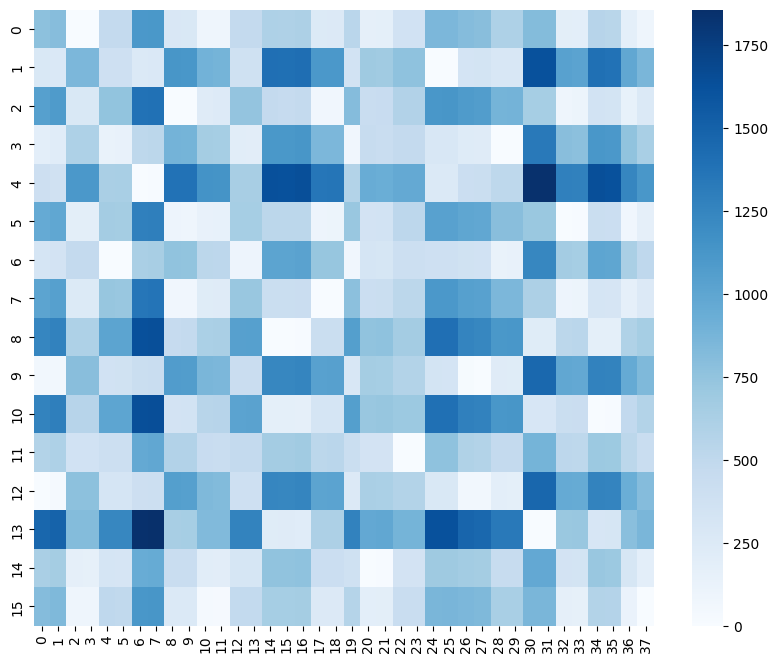

In [286]:
plt.figure(figsize=(10, 8))  # Optional: adjust the size of the heatmap
# Plot the heatmap
sns.heatmap(distance, cmap='Blues')

<Axes: >

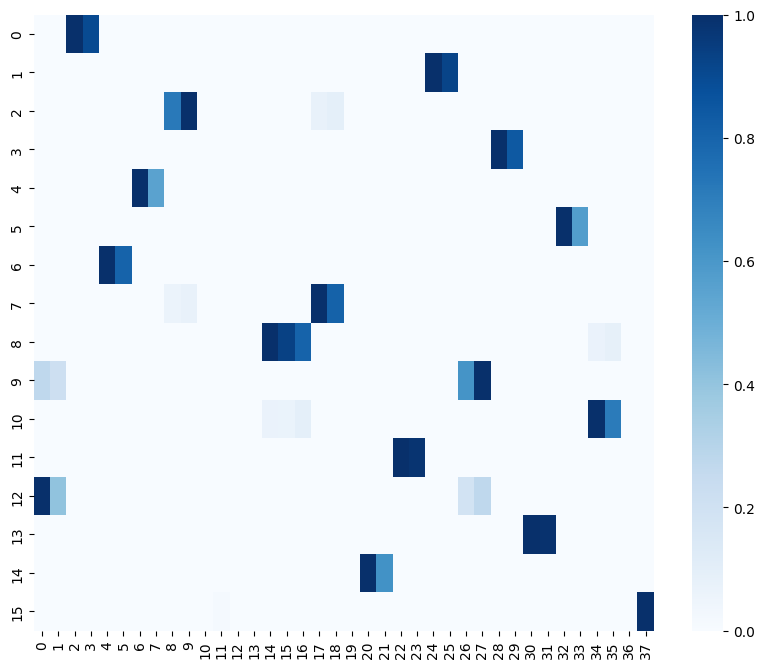

In [287]:
plt.figure(figsize=(10, 8))  # Optional: adjust the size of the heatmap
# Plot the heatmap
sns.heatmap(overlap, cmap='Blues')

In [288]:
bboxes0.shape, bboxes1.shape

((16, 4), (38, 4))

In [289]:
back_img1 = cv.imread("F:\\Dataset\\test_merge_videos_tracklets\\part1\\outputs\\seq_0\\img1\\001767.jpg")
back_img2 = [cv.imread(f"F:\\Dataset\\test_merge_videos_tracklets\\part2\\outputs\\seq_0\\img1\\{i:06d}.jpg") for i in range(5,15)]

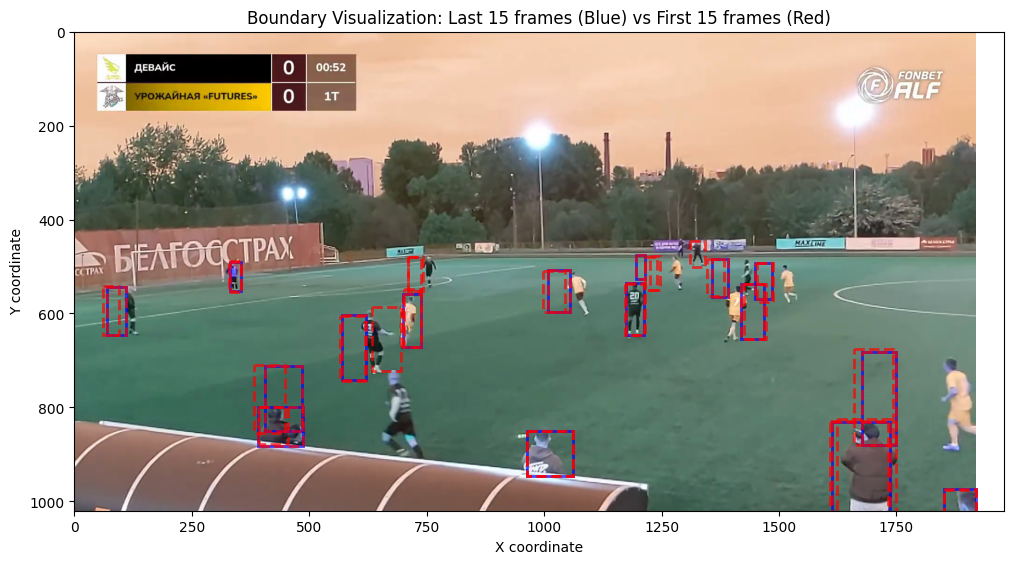

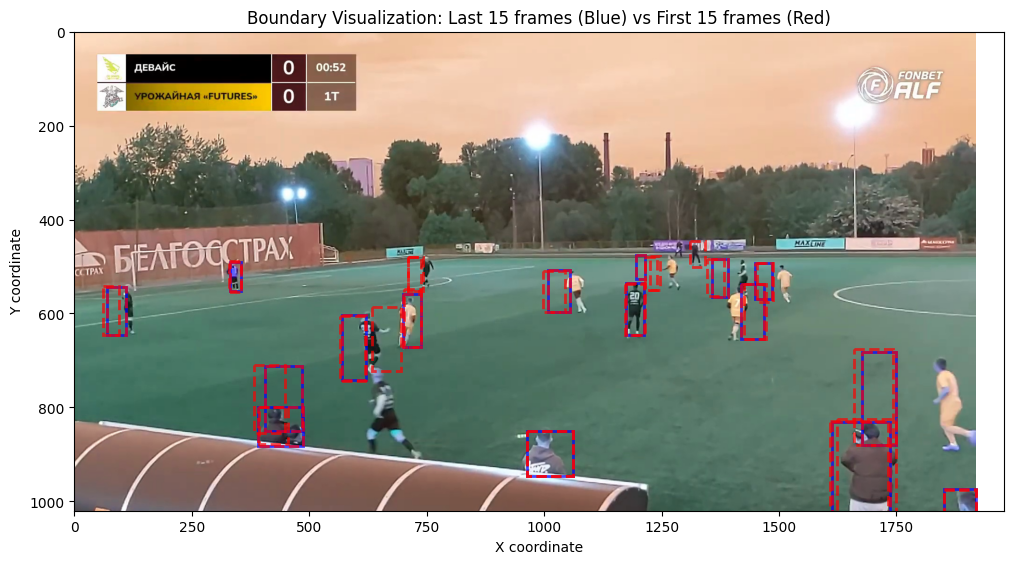

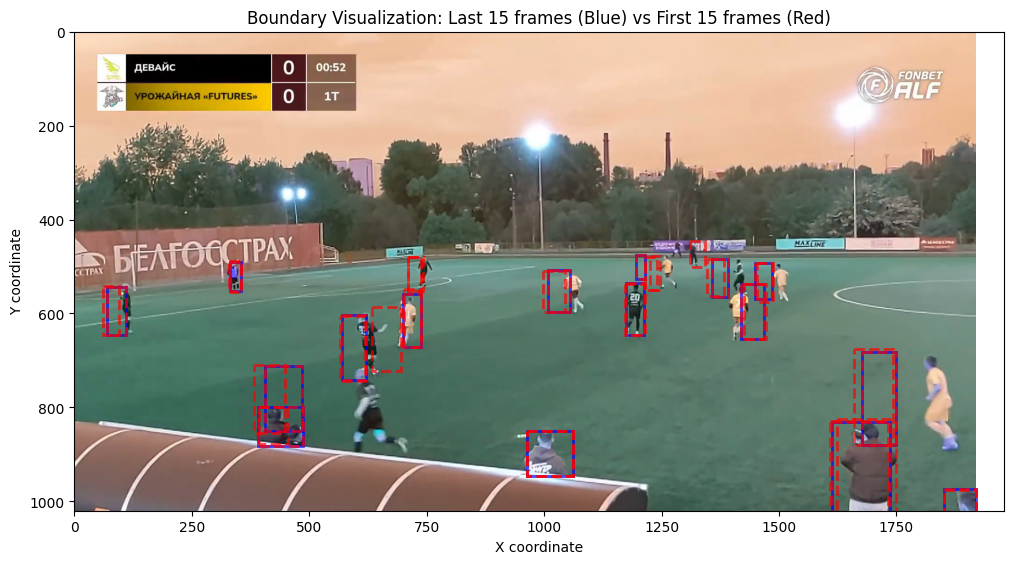

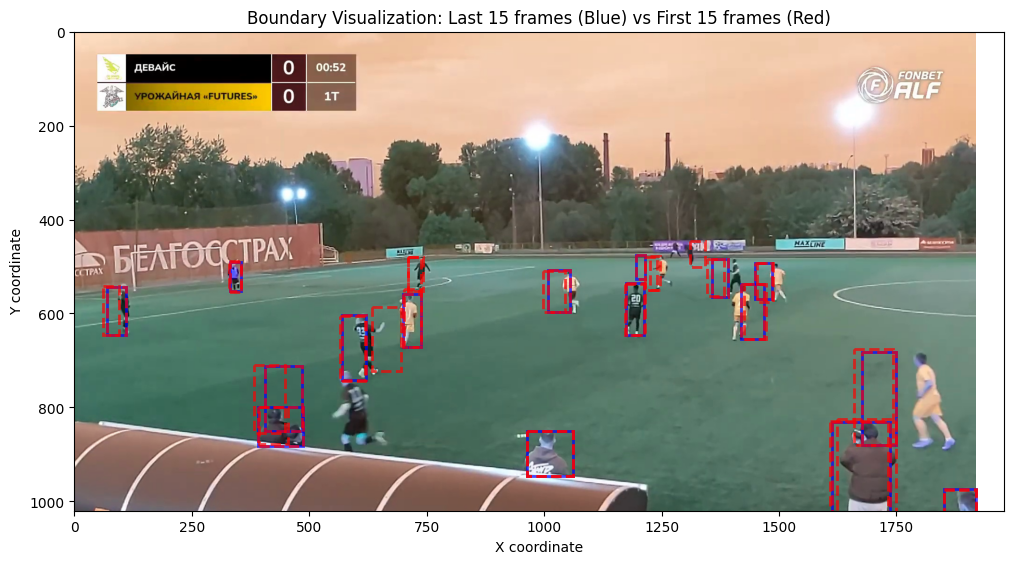

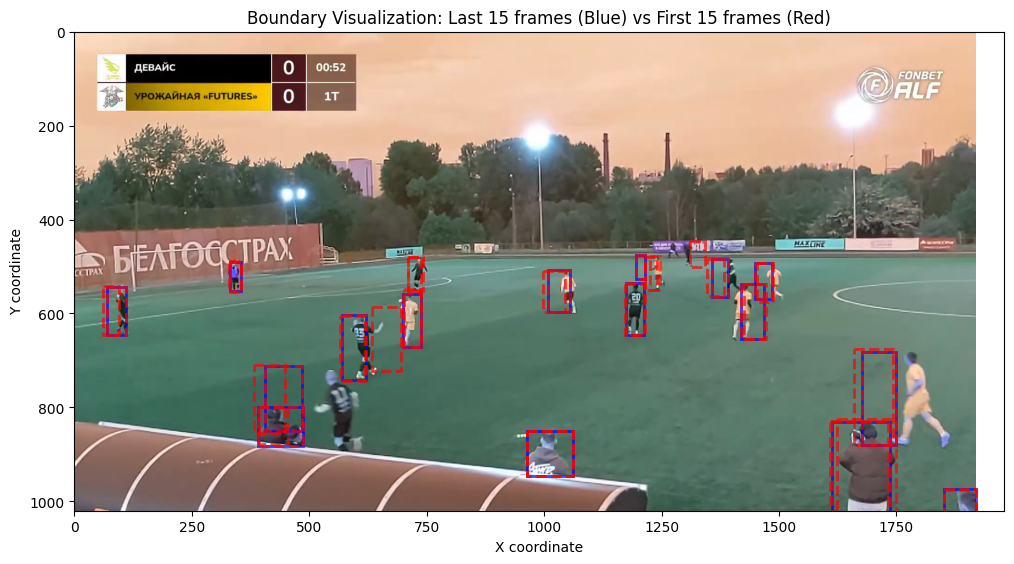

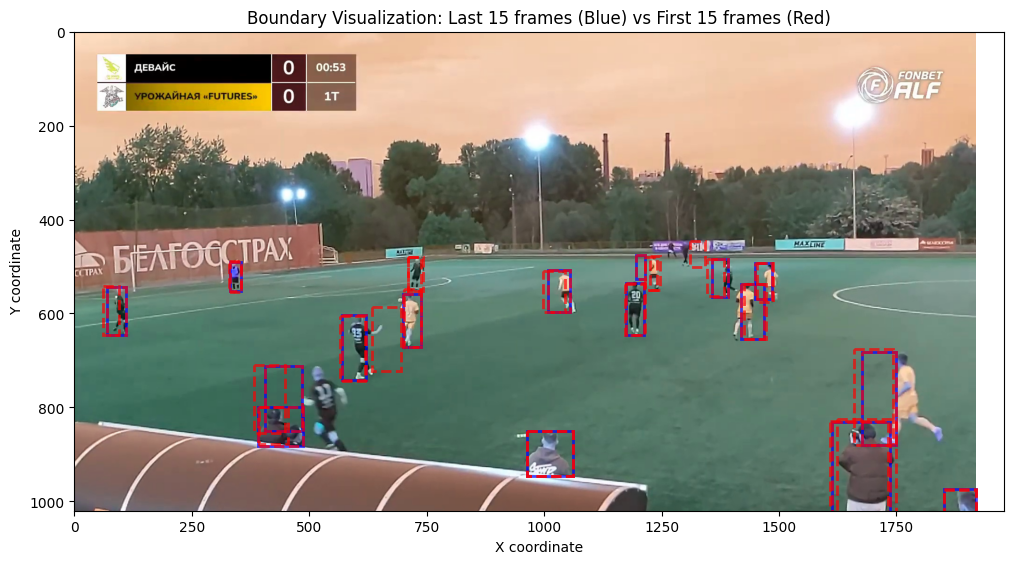

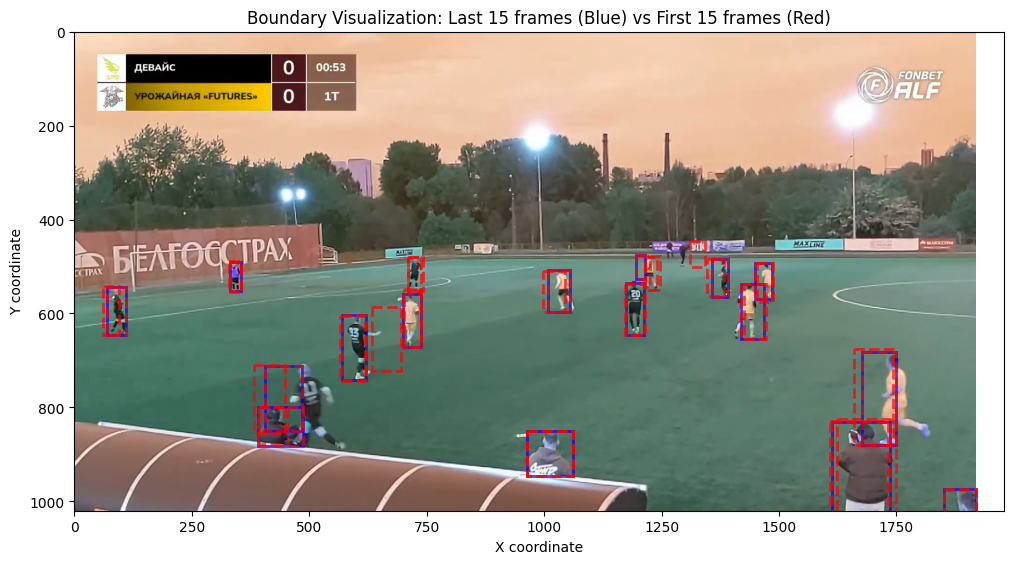

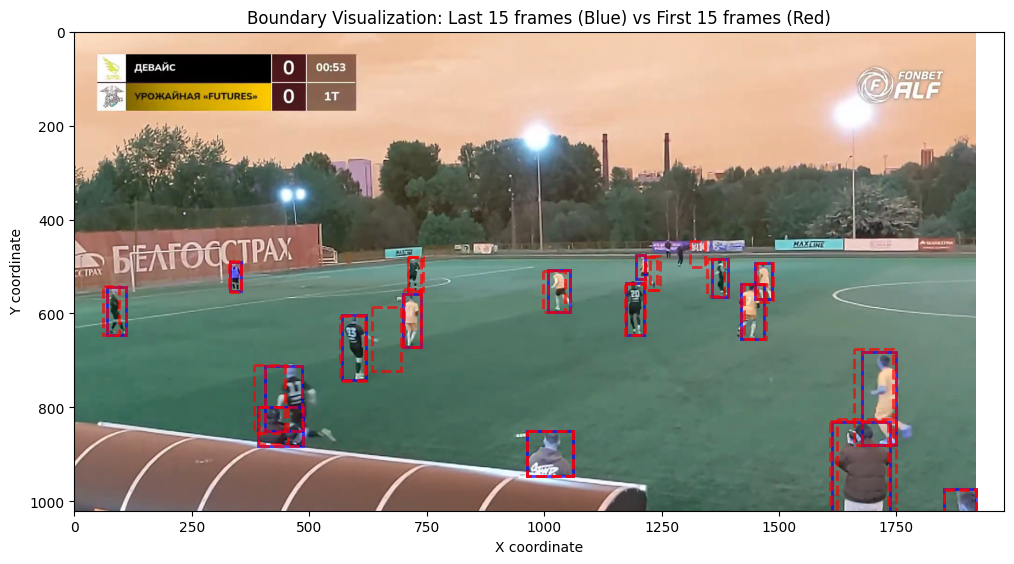

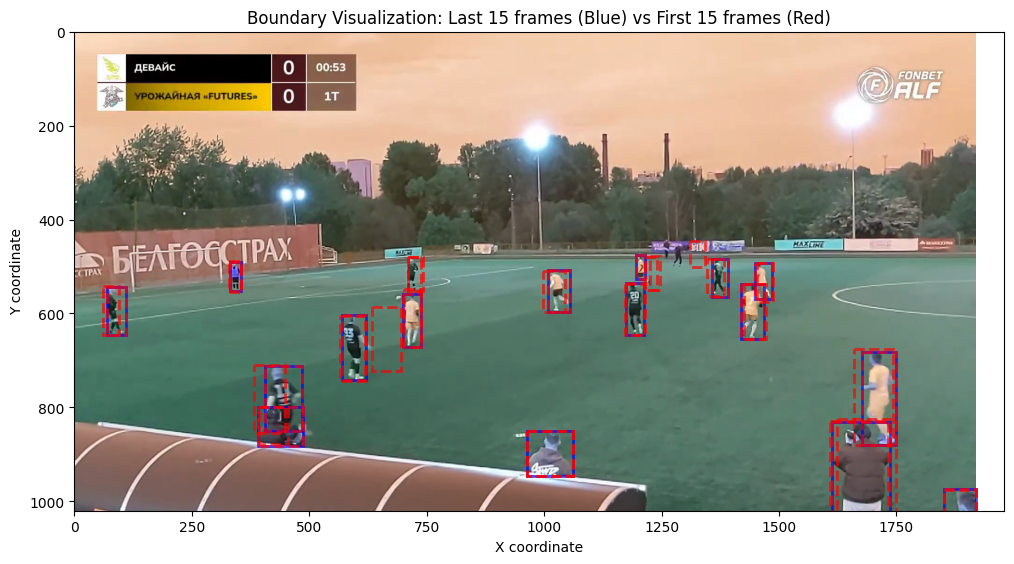

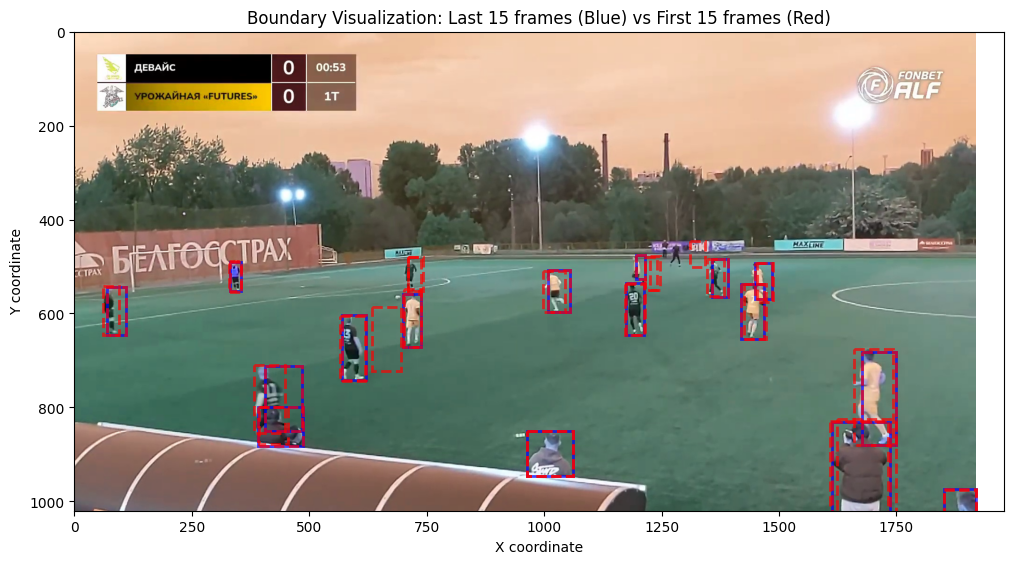

In [290]:
for back_img in back_img2:
    fig, ax = plt.subplots(figsize=(12, 8))
    image_size = (1980, 1020)
    # Set plot limits
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(image_size[1], 0)  # Invert y-axis for image coordinates
    ax.set_title(f"Boundary Visualization: Last {window} frames (Blue) vs First {window} frames (Red)")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.imshow(back_img)
    # Draw bboxes from first video (end)
    for bbox in bboxes0:
        x, y, w, h = bbox
        rect = patches.Rectangle(
            (x, y), w, h, 
            linewidth=2, edgecolor='blue', facecolor='none', 
            linestyle='-', alpha=0.7
        )
        ax.add_patch(rect)
        
    # Draw bboxes from second video (start)
    for bbox in bboxes1:
        x, y, w, h = bbox
        rect = patches.Rectangle(
            (x, y), w, h, 
            linewidth=2, edgecolor='red', facecolor='none', 
            linestyle='--', alpha=0.7
        )
        ax.add_patch(rect)

    plt.show()

In [ ]:
def display_boundary_bboxes(tracklets1, tracklets2, window=1, image_size=None):
    """
    Displays bounding boxes at the end of the first video and start of the second video.
    
    Parameters:
    tracklets1 (dict): Tracklets from first video {track_id: Tracklet}
    tracklets2 (dict): Tracklets from second video {track_id: Tracklet}
    window (int): Number of frames to consider at the boundary
    image_size (tuple): (width, height) of the image. If None, auto-calculated.
    """
    # Find maximum frame in first video
    max_frame1 = 0
    for tr in tracklets1.values():
        if tr.times:
            current_max = max(tr.times)
            if current_max > max_frame1:
                max_frame1 = current_max

    # Collect boundary bboxes from first video
    end_bboxes1 = []
    for tr in tracklets1.values():
        if tr.times and tr.bboxes:
            # Check if tracklet ends in the boundary window
            if max(tr.times) >= max_frame1 - window + 1:
                # Get last bbox
                end_bboxes1.append(tr.bboxes[-1])
    
    # Collect boundary bboxes from second video
    start_bboxes2 = []
    for tr in tracklets2.values():
        if tr.times and tr.bboxes:
            # Check if tracklet starts in the boundary window
            if min(tr.times) <= window:
                # Get first bbox
                start_bboxes2.append(tr.bboxes[0])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Determine image size if not provided
    if image_size is None:
        all_bboxes = end_bboxes1 + start_bboxes2
        if not all_bboxes:
            print("No boundary boxes found")
            return
        max_x = max(bbox[0] + bbox[2] for bbox in all_bboxes)
        max_y = max(bbox[1] + bbox[3] for bbox in all_bboxes)
        image_size = (max_x + 50, max_y + 50)  # Add padding
    
    # Set plot limits
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(image_size[1], 0)  # Invert y-axis for image coordinates
    ax.set_title(f"Boundary Visualization: Last {window} frames (Blue) vs First {window} frames (Red)")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    
    # Draw bboxes from first video (end)
    for bbox in end_bboxes1:
        x, y, w, h = bbox
        rect = patches.Rectangle(
            (x, y), w, h, 
            linewidth=2, edgecolor='blue', facecolor='none', 
            linestyle='-', alpha=0.7
        )
        ax.add_patch(rect)
    
    # Draw bboxes from second video (start)
    for bbox in start_bboxes2:
        x, y, w, h = bbox
        rect = patches.Rectangle(
            (x, y), w, h, 
            linewidth=2, edgecolor='red', facecolor='none', 
            linestyle='--', alpha=0.7
        )
        ax.add_patch(rect)
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label=f'End of First Video (Last {window} frames)'),
        Line2D([0], [0], color='red', lw=2, label=f'Start of Second Video (First {window} frames)'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def find_tracklet_correspondence(tracklets_video1: Dict[int, Tracklet], 
                               tracklets_video2: Dict[int, Tracklet],
                               distance_threshold: float = 50.0,
                               overlap_threshold: float = 0.1,
                               time_window: int = 5) -> Dict[int, int]:
    """
    Find correspondence between tracklets from two consecutive videos
    
    Args:
        tracklets_video1: Dictionary of tracklets from first video
        tracklets_video2: Dictionary of tracklets from second video
        distance_threshold: Maximum distance between bbox centers to consider correspondence
        overlap_threshold: Minimum IoU to consider correspondence
        time_window: Number of frames to look at from end of video1 and start of video2
    
    Returns:
        Dictionary mapping tracklet_id from video1 to tracklet_id from video2
    """
    correspondence_map = {}
    
    for id1, tracklet1 in tracklets_video1.items():
        if not tracklet1.times:
            continue
            
        # Get the last few bounding boxes from video1
        end_indices = max(0, len(tracklet1.times) - time_window)
        end_bboxes1 = tracklet1.bboxes[end_indices:]
        
        best_match_id = None
        best_score = 0
        
        for id2, tracklet2 in tracklets_video2.items():
            if not tracklet2.times:
                continue
                
            # Get the first few bounding boxes from video2
            start_bboxes2 = tracklet2.bboxes[:min(time_window, len(tracklet2.bboxes))]
            
            # Calculate similarity scores between end of tracklet1 and start of tracklet2
            total_score = 0
            comparisons = 0
            
            for bbox1 in end_bboxes1:
                for bbox2 in start_bboxes2:
                    distance = calculate_bbox_distance(bbox1, bbox2)
                    overlap = calculate_bbox_overlap(bbox1, bbox2)
                    
                    if distance < distance_threshold and overlap > overlap_threshold:
                        # Combine distance and overlap into a single score
                        score = overlap * (1 - distance / distance_threshold)
                        total_score += score
                        comparisons += 1
            
            if comparisons > 0:
                avg_score = total_score / comparisons
                if avg_score > best_score:
                    best_score = avg_score
                    best_match_id = id2
        
        if best_match_id is not None and best_score > 0.1:  # Minimum confidence threshold
            correspondence_map[id1] = best_match_id
    
    return correspondence_map

In [48]:
find_tracklet_correspondence(tracklets_spartial[0]['tracklets'], tracklets_spartial[1]['tracklets'])

{}

In [51]:
tracklets_spartial[0]['tracklets'].items()

dict_items([(1.0, <Tracklet.Tracklet object at 0x000001AC60F4A810>), (2.0, <Tracklet.Tracklet object at 0x000001AC610E7B30>), (3.0, <Tracklet.Tracklet object at 0x000001AC611B7DD0>), (4.0, <Tracklet.Tracklet object at 0x000001AC612EE930>), (5.0, <Tracklet.Tracklet object at 0x000001AC614341D0>), (6.0, <Tracklet.Tracklet object at 0x000001AC616A88F0>), (7.0, <Tracklet.Tracklet object at 0x000001AC6144FE60>), (8.0, <Tracklet.Tracklet object at 0x000001AC61496900>), (42.0, <Tracklet.Tracklet object at 0x000001AC61530320>), (44.0, <Tracklet.Tracklet object at 0x000001AC61B1B800>), (46.0, <Tracklet.Tracklet object at 0x000001AC62B644A0>), (47.0, <Tracklet.Tracklet object at 0x000001AC62BAC5C0>), (48.0, <Tracklet.Tracklet object at 0x000001AC62CA2960>), (49.0, <Tracklet.Tracklet object at 0x000001AC62CD7D40>), (50.0, <Tracklet.Tracklet object at 0x000001AC62E01A60>), (52.0, <Tracklet.Tracklet object at 0x000001AC62F67680>), (53.0, <Tracklet.Tracklet object at 0x000001AC62FF1EE0>), (9.0, <Tra

In [86]:
correspondence_map = {}
time_window = 20
distance_threshold: float = 200.0
overlap_threshold: float = 0.01
for id1, tracklet1 in tracklets_spartial[0]['tracklets'].items():
    if not tracklet1.times:
        continue
        
    # Get the last few bounding boxes from video1
    end_indices = max(0, len(tracklet1.times) - time_window)
    end_bboxes1 = tracklet1.bboxes[end_indices:]
    
    best_match_id = None
    best_score = 0.0
    
    for id2, tracklet2 in tracklets_spartial[1]['tracklets'].items():
        if not tracklet2.times:
            continue
            
        # Get the first few bounding boxes from video2
        start_bboxes2 = tracklet2.bboxes[:min(time_window, len(tracklet2.bboxes))]
        
        # Calculate similarity scores between end of tracklet1 and start of tracklet2
        total_score = 0
        comparisons = 0
        for bbox1 in end_bboxes1:
            for bbox2 in start_bboxes2:
                distance = calculate_bbox_distance(bbox1, bbox2)
                overlap = calculate_bbox_overlap(bbox1, bbox2)
                # print(f"bbox1: {bbox1}, bbox2: {bbox2}, distance: {distance}, overlap: {overlap}")
                if distance < distance_threshold and overlap > overlap_threshold:
                    # Combine distance and overlap into a single score
                    score = overlap * (1 - distance / distance_threshold)
                    total_score += score
                    comparisons += 1
        
        if comparisons > 0:
            avg_score = total_score / comparisons
            print(f"{id1} vs {id2}: best_score={best_score}, avg_score={avg_score}")            
            if avg_score > best_score:
                best_score = avg_score
                best_match_id = id2

    if best_match_id is not None and best_score > 0.0001:  # Minimum confidence threshold
        correspondence_map[id1] = best_match_id        

45.0 vs 5.0: best_score=0.0, avg_score=0.0010681537552968932
45.0 vs 60.0: best_score=0.0010681537552968932, avg_score=0.0008125130299658516
45.0 vs 11.0: best_score=0.0010681537552968932, avg_score=0.0010387377225526693
45.0 vs 63.0: best_score=0.0010681537552968932, avg_score=0.0008401893709040182
45.0 vs 19.0: best_score=0.0010681537552968932, avg_score=0.0012351023145714258
45.0 vs 70.0: best_score=0.0012351023145714258, avg_score=0.0009199106938535367
26.0 vs 33.0: best_score=0.0, avg_score=0.0002003956576335869
26.0 vs 34.0: best_score=0.0002003956576335869, avg_score=0.00030523822066357703
34.0 vs 18.0: best_score=0.0, avg_score=4.754922540666404e-05
34.0 vs 28.0: best_score=4.754922540666404e-05, avg_score=0.00028782765872126275
34.0 vs 39.0: best_score=0.00028782765872126275, avg_score=0.0006570109586302987
36.0 vs 9.0: best_score=0.0, avg_score=8.546978712798037e-05
38.0 vs 26.0: best_score=0.0, avg_score=0.0007078012945208013


In [87]:
correspondence_map

{45.0: 19.0, 26.0: 34.0, 34.0: 39.0, 38.0: 26.0}